In [ ]:
!pip install torch

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
#!pip freeze > new_lambda_requirements.txt
!pwd

/home/ubuntu/chemical_informatics


In [ ]:
!pip install python-dotenv

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.36ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: tensorflow-gpu 2.11.0 has a non-standard dependency specifier platform_system!="Darwin". pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of tensorfl

In [ ]:
import pandas as pd
import os
import requests
import json
import csv
import io
from collections import defaultdict
from time import time
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
#from flair.data import Sentence
#from flair.nn import Classifier
#from chembl_webresource_client.new_client import new_client
from sqlalchemy import create_engine
from sqlalchemy import text

# 1. Get targets from disease

In [ ]:
"""
insert code here that
1. Takes an EFO as input
2. displays a dataframe of targets for that disease
3. uploads that dataframe to a table in planetscale called "disease_to_target"

"""
from sqlalchemy import create_engine
from dotenv import dotenv_values
from sqlalchemy import text
config = dotenv_values('database_url.env')
url = config['DATABASE_URL']

engine = create_engine(url, echo=False)



## Set disease_id variable for desired disease

disease_id = "EFO_0005537"


with engine.begin() as conn:
    query = text("SELECT * FROM disease_to_target WHERE disease_id = '{disease_id}';".format(disease_id = disease_id))
    disease_df = pd.read_sql(query, conn)

display(disease_df)


target_ids = disease_df.sort_values(by = ['association_score'], ascending=False)['target_ensemble_id'].values
print(target_ids)
target_id = target_ids[1]

print(target_id)
print(type(target_id))

,index,disease_id,target_ensemble_id,target_chembl_id,association_score
0,0,EFO_0005537,ENSG00000184292,CHEMBL3856163,0.431490
1,1,EFO_0005537,ENSG00000198900,CHEMBL1781,0.424207
2,2,EFO_0005537,ENSG00000120217,CHEMBL3580522,0.405569
3,3,EFO_0005537,ENSG00000258947,CHEMBL2597,0.402827
4,4,EFO_0005537,ENSG00000137267,CHEMBL3797012,0.399973
...,...,...,...,...,...
5012,5012,EFO_0005537,ENSG00000135164,CHEMBL3707469,0.001478
5013,5013,EFO_0005537,ENSG00000115665,CHEMBL4507,0.001478
5014,5014,EFO_0005537,ENSG00000146109,CHEMBL4507,0.001478
5015,5015,EFO_0005537,ENSG00000225830,CHEMBL4507,0.001478


['ENSG00000184292' 'ENSG00000198900' 'ENSG00000120217' ...
 'ENSG00000072133' 'ENSG00000069020' 'ENSG00000183542']
ENSG00000198900
<class 'str'>


# 2. Get compounds and assays

In [ ]:
"""
insert code here that
1. takes a target as input
2. searches the database for compounds and assays for that target
3. displays a dataframe with at least these columns: target id, compound id, assay id
"""
engine = create_engine(url, echo=False)
#target_id = 'CHEMBL4776444'


with engine.begin() as conn:
    query = text("SELECT * FROM target_to_compounds WHERE target_ensemble_id='{target}';".format(target=target_id))
    target_to_compounds_df = pd.read_sql(query, conn)

display(target_to_compounds_df)



,index,compound_id,smiles,type,standard_value,assay_id,assay_type,assay_description,document_id,abstract,target_ensemble_id
0,0,CHEMBL3968023,C[n+]1ccc2c3c(nc4cc5c(cc42)OCO5)-c2ccccc2-c31....,IC50,0.45,CHEMBL3867357,B,Inhibition of human DNA topoisomerase 1 using ...,CHEMBL3865847,"Eupolauridine, an indenonaphthyridine alkaloid...",ENSG00000198900
1,1,CHEMBL3914791,C[n+]1c2c3c(nc(-c4ccccc4)cc3c3ccccc31)-c1ccccc...,IC50,0.475,CHEMBL3867357,B,Inhibition of human DNA topoisomerase 1 using ...,CHEMBL3865847,"Eupolauridine, an indenonaphthyridine alkaloid...",ENSG00000198900
2,2,CHEMBL3896867,[Br-].c1ccc(C[n+]2ccc3c4c(nc5cc6c(cc53)OCO6)-c...,IC50,0.52,CHEMBL3867357,B,Inhibition of human DNA topoisomerase 1 using ...,CHEMBL3865847,"Eupolauridine, an indenonaphthyridine alkaloid...",ENSG00000198900
3,3,CHEMBL3889816,[Br-].c1ccc(C[n+]2ccc3c4c(nc5ccccc53)-c3ccccc3...,IC50,0.57,CHEMBL3867357,B,Inhibition of human DNA topoisomerase 1 using ...,CHEMBL3865847,"Eupolauridine, an indenonaphthyridine alkaloid...",ENSG00000198900
4,4,CHEMBL3984603,Cc1cc2c3c(nc4ccccc42)-c2ccccc2-c3[n+]1C.[I-],IC50,0.7,CHEMBL3867357,B,Inhibition of human DNA topoisomerase 1 using ...,CHEMBL3865847,"Eupolauridine, an indenonaphthyridine alkaloid...",ENSG00000198900
...,...,...,...,...,...,...,...,...,...,...,...
451,451,CHEMBL426092,O=C1Oc2ccc(O)cc2/C1=C\c1ccc(O)cc1,IC50,555000.0,CHEMBL827155,B,Inhibitory concentration against DNA topoisome...,CHEMBL1143530,Isoaurostatin A (IAS-A) isolated from Thermomo...,ENSG00000198900
452,452,CHEMBL9164,CCCCCCC(=O)O[C@H](CC=C(C)C)C1=CC(=O)c2c(O)ccc(...,IC50,625000.0,CHEMBL663903,B,Inhibitory activity against DNA topoisomerase-...,CHEMBL1128571,Compounds bearing an acyl group of a various s...,ENSG00000198900
453,453,CHEMBL372372,COc1cc(/C=C2/C(=O)Oc3ccccc32)ccc1O,IC50,630000.0,CHEMBL827155,B,Inhibitory concentration against DNA topoisome...,CHEMBL1143530,Isoaurostatin A (IAS-A) isolated from Thermomo...,ENSG00000198900
454,454,CHEMBL381195,COc1ccc(/C=C2/C(=O)Oc3ccccc32)cc1O,IC50,800000.0,CHEMBL827155,B,Inhibitory concentration against DNA topoisome...,CHEMBL1143530,Isoaurostatin A (IAS-A) isolated from Thermomo...,ENSG00000198900


# 3. Propose a new compound

In [ ]:
# need to tell deepchem where to find cuda

In [ ]:
%env XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/lib/cuda

env: XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/lib/cuda


In [ ]:
!pip install --pre deepchem[tensorflow]

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for deepchem[tensorflow] from https://files.pythonhosted.org/packages/83/fc/88bf5075978b48a5ff0025a729a9da7638aae5fe58c8b834b14ef01ac6c1/deepchem-2.7.2.dev20230724021110-py3-none-any.whl.metadata
  Using cached deepchem-2.7.2.dev20230724021110-py3-none-any.whl.metadata (1.9 kB)
Using cached deepchem-2.7.2.dev20230724021110-py3-none-any.whl (825 kB)
DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.36ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytho

In [ ]:
pip install --upgrade scikit-learn

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/bf/15/d1b649fc7685d11b806b4546a5438191fb2ad761de70da95ff676189dcec/scikit_learn-1.3.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for threadpoolctl>=2.0.0 from https://files.pythonhosted.org/packages/81/12/fd4dea011af9d69e1cad05c75f3f7202cdcbeac9b712eea58ca779a72865/threadpoolctl-3.2.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 151.1 MB/s eta 0:00:0000:010:01
DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: py

In [ ]:
"""
insert code here that
1. trains a model to predict ic50 values for a compound on a given target
2. downloads ALL the compounds in the database (independent of target)
3. runs the model to predict ic50 values for each compound in the database
4. displays a dataframe that has the following two columns : compound, predicted ic50
5. prints out the compound that has the highest ic50 value that has NOT been tested on the target already.
"""
# 1. Train Model
import deepchem as dc
import numpy as np

import os

import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)

#!git clone https://github.com/dsalinasduron-msmary/chemical_informatics.git

import os
import pickle
#os.listdir()
#os.chdir('chemical_informatics')
#os.getcwd()
"""
f = open('ENSG00000128191dataframe.pickle','rb')
compound_dataset = pickle.load(f)
f.close()
display(compound_dataset)
"""
compound_dataset = target_to_compounds_df
smiles = compound_dataset['smiles']
IC50 = compound_dataset['standard_value']
featurizer = dc.feat.ConvMolFeaturizer()
compound_dataset['featurized'] = featurizer.featurize(smiles)
compound_dataset['divided values'] = compound_dataset['standard_value'].astype(float).div(108000)
compound_dataset['pIC50'] = np.log10(compound_dataset['divided values'].astype(float)).mul(-1)
compound_dataset['number'] = list(range(0,len(compound_dataset)))
display(compound_dataset)

#compound_dataset['pIC50'].hist()
"""
x = compound_dataset
f = open('x.pickle','wb')
pickle.dump(x,f)
f.close()
"""
import pandas as pd
training_dataset = compound_dataset.sample(frac = 0.7)

#training_dataset.featurized[0].n_feat

testing_dataset = (compound_dataset[~compound_dataset['number'].isin(training_dataset['number'])])
display(testing_dataset)

numpy_training_dataset = dc.data.NumpyDataset(X=training_dataset['featurized'],y=training_dataset['pIC50'].astype(float), ids=training_dataset['smiles'])
numpy_testing_dataset = dc.data.NumpyDataset(X=testing_dataset['featurized'],y=testing_dataset['pIC50'].astype(float), ids=testing_dataset['smiles'])
display(numpy_training_dataset)
display(numpy_testing_dataset)

model = dc.models.GraphConvModel(n_tasks=1, mode='regression', dropout=0.2, dense_layer_size=10)

model.fit(numpy_training_dataset, nb_epoch=100)

#model = dc.models.GraphConvModel(n_tasks=1, mode='regression', dropout=0.2, dense_layer_size=10, model_dir="./compund_model")
#model.restore()

metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print("Training set score:", model.evaluate(numpy_training_dataset, [metric]))
print("Test set score:", model.evaluate(numpy_testing_dataset, [metric]))


#2. Download all compounds in database
with engine.begin() as conn:
    query = text("SELECT compound_id,smiles FROM target_to_compounds;")
    compounds_df = pd.read_sql(query, conn)

predict_list = []
for smile in range(0, len(compounds_df)):
    predict_list.append(None)
print(len(predict_list))

compounds_df['predicted_pIC50'] = predict_list

curated_compounds_df = compounds_df.dropna(subset=['smiles'])

new_smiles = curated_compounds_df['smiles']
curated_compounds_df['featurized'] = featurizer.featurize(new_smiles)

#3. run the model to predict ic50 values for each compound in the database
dataset = dc.data.NumpyDataset(X=curated_compounds_df['featurized'], y=curated_compounds_df['predicted_pIC50'], ids=curated_compounds_df['smiles'])
curated_compounds_df['predicted_pIC50'] = model.predict(dataset)



# 4. displays a dataframe that has the following two columns : compound, predicted ic50
display(curated_compounds_df)

2.13.0


,index,compound_id,smiles,type,standard_value,assay_id,assay_type,assay_description,document_id,abstract,target_ensemble_id,featurized,divided values,pIC50,number
0,0,CHEMBL3968023,C[n+]1ccc2c3c(nc4cc5c(cc42)OCO5)-c2ccccc2-c31....,IC50,0.45,CHEMBL3867357,B,Inhibition of human DNA topoisomerase 1 using ...,CHEMBL3865847,"Eupolauridine, an indenonaphthyridine alkaloid...",ENSG00000198900,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.000004,5.380211,0
1,1,CHEMBL3914791,C[n+]1c2c3c(nc(-c4ccccc4)cc3c3ccccc31)-c1ccccc...,IC50,0.475,CHEMBL3867357,B,Inhibition of human DNA topoisomerase 1 using ...,CHEMBL3865847,"Eupolauridine, an indenonaphthyridine alkaloid...",ENSG00000198900,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.000004,5.356730,1
2,2,CHEMBL3896867,[Br-].c1ccc(C[n+]2ccc3c4c(nc5cc6c(cc53)OCO6)-c...,IC50,0.52,CHEMBL3867357,B,Inhibition of human DNA topoisomerase 1 using ...,CHEMBL3865847,"Eupolauridine, an indenonaphthyridine alkaloid...",ENSG00000198900,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.000005,5.317420,2
3,3,CHEMBL3889816,[Br-].c1ccc(C[n+]2ccc3c4c(nc5ccccc53)-c3ccccc3...,IC50,0.57,CHEMBL3867357,B,Inhibition of human DNA topoisomerase 1 using ...,CHEMBL3865847,"Eupolauridine, an indenonaphthyridine alkaloid...",ENSG00000198900,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.000005,5.277549,3
4,4,CHEMBL3984603,Cc1cc2c3c(nc4ccccc42)-c2ccccc2-c3[n+]1C.[I-],IC50,0.7,CHEMBL3867357,B,Inhibition of human DNA topoisomerase 1 using ...,CHEMBL3865847,"Eupolauridine, an indenonaphthyridine alkaloid...",ENSG00000198900,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.000006,5.188326,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,451,CHEMBL426092,O=C1Oc2ccc(O)cc2/C1=C\c1ccc(O)cc1,IC50,555000.0,CHEMBL827155,B,Inhibitory concentration against DNA topoisome...,CHEMBL1143530,Isoaurostatin A (IAS-A) isolated from Thermomo...,ENSG00000198900,<deepchem.feat.mol_graphs.ConvMol object at 0x...,5.138889,-0.710869,451
452,452,CHEMBL9164,CCCCCCC(=O)O[C@H](CC=C(C)C)C1=CC(=O)c2c(O)ccc(...,IC50,625000.0,CHEMBL663903,B,Inhibitory activity against DNA topoisomerase-...,CHEMBL1128571,Compounds bearing an acyl group of a various s...,ENSG00000198900,<deepchem.feat.mol_graphs.ConvMol object at 0x...,5.787037,-0.762456,452
453,453,CHEMBL372372,COc1cc(/C=C2/C(=O)Oc3ccccc32)ccc1O,IC50,630000.0,CHEMBL827155,B,Inhibitory concentration against DNA topoisome...,CHEMBL1143530,Isoaurostatin A (IAS-A) isolated from Thermomo...,ENSG00000198900,<deepchem.feat.mol_graphs.ConvMol object at 0x...,5.833333,-0.765917,453
454,454,CHEMBL381195,COc1ccc(/C=C2/C(=O)Oc3ccccc32)cc1O,IC50,800000.0,CHEMBL827155,B,Inhibitory concentration against DNA topoisome...,CHEMBL1143530,Isoaurostatin A (IAS-A) isolated from Thermomo...,ENSG00000198900,<deepchem.feat.mol_graphs.ConvMol object at 0x...,7.407407,-0.869666,454


,index,compound_id,smiles,type,standard_value,assay_id,assay_type,assay_description,document_id,abstract,target_ensemble_id,featurized,divided values,pIC50,number
3,3,CHEMBL3889816,[Br-].c1ccc(C[n+]2ccc3c4c(nc5ccccc53)-c3ccccc3...,IC50,0.57,CHEMBL3867357,B,Inhibition of human DNA topoisomerase 1 using ...,CHEMBL3865847,"Eupolauridine, an indenonaphthyridine alkaloid...",ENSG00000198900,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.000005,5.277549,3
5,5,CHEMBL3932774,CC[n+]1ccc2c3c(nc4ccccc42)-c2ccccc2-c31.[I-],IC50,0.7,CHEMBL3867357,B,Inhibition of human DNA topoisomerase 1 using ...,CHEMBL3865847,"Eupolauridine, an indenonaphthyridine alkaloid...",ENSG00000198900,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.000006,5.188326,5
10,10,CHEMBL3960953,[Br-].c1ccc(C[n+]2ccc3cc(-c4ccccc4)nc4c3c2-c2c...,IC50,4.4,CHEMBL3867357,B,Inhibition of human DNA topoisomerase 1 using ...,CHEMBL3865847,"Eupolauridine, an indenonaphthyridine alkaloid...",ENSG00000198900,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.000041,4.389971,10
11,11,CHEMBL3904207,Cc1cc2cc[n+](C)c3c2c(n1)-c1ccccc1-3.[I-],IC50,4.5,CHEMBL3867357,B,Inhibition of human DNA topoisomerase 1 using ...,CHEMBL3865847,"Eupolauridine, an indenonaphthyridine alkaloid...",ENSG00000198900,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.000042,4.380211,11
15,15,CHEMBL338843,CC[C@@]1(O)C(=O)OCc2c1cc1n(c2=O)Cc2c-1nc1cc3c(...,IC50,11.0,CHEMBL663645,B,Inhibition of topoisomerase I activity was det...,CHEMBL1128223,The synthesis and antitumor activities of the ...,ENSG00000198900,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.000102,3.992031,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446,446,CHEMBL194829,O=C1Oc2ccccc2/C1=C\c1cccc(O)c1,IC50,262000.0,CHEMBL827155,B,Inhibitory concentration against DNA topoisome...,CHEMBL1143530,Isoaurostatin A (IAS-A) isolated from Thermomo...,ENSG00000198900,<deepchem.feat.mol_graphs.ConvMol object at 0x...,2.425926,-0.384878,446
447,447,CHEMBL195416,O=C1Oc2cc(O)ccc2/C1=C\c1ccc(O)cc1,IC50,307000.0,CHEMBL827155,B,Inhibitory concentration against DNA topoisome...,CHEMBL1143530,Isoaurostatin A (IAS-A) isolated from Thermomo...,ENSG00000198900,<deepchem.feat.mol_graphs.ConvMol object at 0x...,2.842593,-0.453715,447
449,449,CHEMBL282299,c1coc(-c2ccnc(-c3cccs3)c2)c1,IC50,400000.0,CHEMBL669803,B,Inhibitory activity against the wheat germ DNA...,CHEMBL1147612,"For the development of new anticancer agents, ...",ENSG00000198900,<deepchem.feat.mol_graphs.ConvMol object at 0x...,3.703704,-0.568636,449
451,451,CHEMBL426092,O=C1Oc2ccc(O)cc2/C1=C\c1ccc(O)cc1,IC50,555000.0,CHEMBL827155,B,Inhibitory concentration against DNA topoisome...,CHEMBL1143530,Isoaurostatin A (IAS-A) isolated from Thermomo...,ENSG00000198900,<deepchem.feat.mol_graphs.ConvMol object at 0x...,5.138889,-0.710869,451


<NumpyDataset X.shape: (319,), y.shape: (319,), w.shape: (319,), ids: ['O=c1c(C(c2ccc(C(c3c(O)oc4ccccc4c3=O)c3c(O)oc4ccccc4c3=O)cc2)c2c(O)oc3ccccc3c2=O)c(O)oc2ccccc12'
 'CC[C@@]1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(CN(C)C)c(O)ccc3nc2-1'
 'CC[C@@](O)(C(=O)[O-])c1cc2n(c(=O)c1CO)Cc1cc3cc4c(cc3nc1-2)OCO4.[Na+]'
 ... 'Cc1ccc(C[n+]2ccc3ccnc4c3c2-c2ccccc2-4)cc1.[Br-]'
 'CCC(O)c1cc(OC)c2c(c1OC)C(=O)C=CC2=O'
 'CC[C@@]1(O)C(=O)OCc2c1cc1n(c2=O)Cc2c-1nc1cc3c(cc1c2CCl)OCO3'], task_names: [0]>

<NumpyDataset X.shape: (137,), y.shape: (137,), w.shape: (137,), ids: ['[Br-].c1ccc(C[n+]2ccc3c4c(nc5ccccc53)-c3ccccc3-c42)cc1'
 'CC[n+]1ccc2c3c(nc4ccccc42)-c2ccccc2-c31.[I-]'
 '[Br-].c1ccc(C[n+]2ccc3cc(-c4ccccc4)nc4c3c2-c2ccccc2-4)cc1' ...
 'c1coc(-c2ccnc(-c3cccs3)c2)c1' 'O=C1Oc2ccc(O)cc2/C1=C\\c1ccc(O)cc1'
 'COc1ccc(/C=C2/C(=O)Oc3ccccc32)cc1O'], task_names: [0]>

Training set score: {'pearson_r2_score': 0.8075831003971295}
Test set score: {'pearson_r2_score': 0.7234511637249842}
13752


<ipython-input-74-a2db5e98c323>:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curated_compounds_df['featurized'] = featurizer.featurize(new_smiles)
<ipython-input-74-a2db5e98c323>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curated_compounds_df['predicted_pIC50'] = model.predict(dataset)


,compound_id,smiles,predicted_pIC50,featurized
0,CHEMBL570841,N=C1NC(=O)/C(=C/c2ccc(O)cc2)S1,-0.010340,<deepchem.feat.mol_graphs.ConvMol object at 0x...
1,CHEMBL570841,N=C1NC(=O)/C(=C/c2ccc(O)cc2)S1,-0.010340,<deepchem.feat.mol_graphs.ConvMol object at 0x...
2,CHEMBL4128424,O=C(COc1ccc2c(-c3ccccc3)cc(=O)oc2c1)NN1C(=O)CS...,-0.237961,<deepchem.feat.mol_graphs.ConvMol object at 0x...
3,CHEMBL107,COc1cc2c(c(OC)c1OC)-c1ccc(OC)c(=O)cc1[C@@H](NC...,-0.093427,<deepchem.feat.mol_graphs.ConvMol object at 0x...
4,CHEMBL4127437,COc1cc(C2SCC(=O)N2NC(=O)COc2ccc3c(-c4ccccc4)cc...,-0.178462,<deepchem.feat.mol_graphs.ConvMol object at 0x...
...,...,...,...,...
13747,CHEMBL7976,O=C(/C=C/c1ccccc1)c1ccccc1,-0.493837,<deepchem.feat.mol_graphs.ConvMol object at 0x...
13748,CHEMBL107,COc1cc2c(c(OC)c1OC)-c1ccc(OC)c(=O)cc1[C@@H](NC...,-0.093696,<deepchem.feat.mol_graphs.ConvMol object at 0x...
13749,CHEMBL18869,COc1cccc(-c2nc(O)c3cc(OC)ccc3n2)c1,0.176590,<deepchem.feat.mol_graphs.ConvMol object at 0x...
13750,CHEMBL278647,COc1cccc(-c2nc(O)c3cc(OC)c(OC)cc3n2)c1,-0.562091,<deepchem.feat.mol_graphs.ConvMol object at 0x...


In [ ]:
# 5. print out the compound that has the highest ic50 value that has NOT been tested on the target already.

curated_compounds_no_target = (curated_compounds_df[~curated_compounds_df['smiles'].isin(target_to_compounds_df['smiles'])])



df = curated_compounds_no_target.sort_values(by = ['predicted_pIC50'], ascending=False)
df.drop_duplicates(subset = 'smiles', inplace = True)

display(df)
compound_ids = df['compound_id'].values
compound_smiles = df['smiles'].values

compound_ids_and_smiles = list(zip(compound_ids, compound_smiles))
best_compound = (compound_ids_and_smiles[0])

# 6. get InChI key for top compound and generate a url for Zinc

url = "https://cactus.nci.nih.gov/chemical/structure/{smiles}/stdinchikey".format(smiles = best_compound[1])
r = requests.get(url=url)
raw_inchikey = r.text
inchikey = raw_inchikey.split('=')[1]

print(inchikey)

zinc_url = 'https://zinc15.docking.org/substances/?inchikey={inchikey}'.format(inchikey = inchikey)
print(zinc_url)

,compound_id,smiles,predicted_pIC50,featurized
2043,CHEMBL3780961,Cc1c2c[n+](C)ccc2cc2c1c1ccccc1n2C.[I-],3.502610,<deepchem.feat.mol_graphs.ConvMol object at 0x...
2022,CHEMBL123,Cc1c2ccncc2c(C)c2c1[nH]c1ccccc12,3.268403,<deepchem.feat.mol_graphs.ConvMol object at 0x...
1679,CHEMBL388978,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...,3.252365,<deepchem.feat.mol_graphs.ConvMol object at 0x...
2221,CHEMBL3780229,Cc1c2cnccc2cc2c1c1ccccc1n2C,3.084920,<deepchem.feat.mol_graphs.ConvMol object at 0x...
3704,CHEMBL424708,Cc1nc(C)c(-c2csc(Nc3ccc(Br)cc3)n2)s1,3.068021,<deepchem.feat.mol_graphs.ConvMol object at 0x...
...,...,...,...,...
6734,CHEMBL86326,COc1ccc(/C=C2\C(=O)Nc3ccc(Cl)cc32)cc1C(C)(C)C,-1.803104,<deepchem.feat.mol_graphs.ConvMol object at 0x...
3464,CHEMBL5197739,CC[C@H](C)[C@@H]([C@@H](CC(=O)OC(C)(C)C)OC)N(C...,-1.855533,<deepchem.feat.mol_graphs.ConvMol object at 0x...
6704,CHEMBL86945,COc1ccc(/C=C2\C(=O)Nc3ccccc32)cc1C(C)(C)C,-1.934276,<deepchem.feat.mol_graphs.ConvMol object at 0x...
9529,CHEMBL3298512,C=CC(=O)[C@H](Cc1ccccc1)NC(=O)OC(C)(C)C,-1.978775,<deepchem.feat.mol_graphs.ConvMol object at 0x...


ABLCIRFOALJFEI-UHFFFAOYSA-M
https://zinc15.docking.org/substances/?inchikey=ABLCIRFOALJFEI-UHFFFAOYSA-M


In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw, PyMol, rdFMCS
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
from deepchem import metrics
from IPython.display import Image, display
from rdkit.Chem.Draw import SimilarityMaps
import tensorflow as tf

In [ ]:
small_df = df.head(10)
dataset = dc.data.NumpyDataset(X=small_df['featurized'],y=small_df['predicted_pIC50'].astype(float), ids=small_df['smiles'])

In [ ]:
#compound_dataset['smi_to_mol'] = Chem.SmilesMolSupplierFromText(compound_dataset['smiles'].values.tolist())
#pd.DataFrame.to_csv(compound_dataset)
just_smiles_df = pd.DataFrame()
#just_smiles_df['smiles'] = compound_dataset['smiles']
just_smiles_df['smiles'] = small_df['smiles']
smiles = just_smiles_df['smiles'].tolist
small_smiles = just_smiles_df.head(10)
#just_smiles_df['name'] = [-1 for thing in smiles]
just_smiles_df['name'] = just_smiles_df['smiles']
#print(just_smiles_df)
just_smiles_df.to_csv('smiles.csv', index = False)

In [ ]:
smiles = small_df['smiles']
featurizer = dc.feat.ConvMolFeaturizer(per_atom_fragmentation = True)
small_df['frag_featurized'] = featurizer.featurize(smiles)


/home/ubuntu/.local/lib/python3.8/site-packages/deepchem/feat/base_classes.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(features)
<ipython-input-79-a3e60e64786c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['frag_featurized'] = featurizer.featurize(smiles)


In [ ]:
display(small_df)

,compound_id,smiles,predicted_pIC50,featurized,frag_featurized
2043,CHEMBL3780961,Cc1c2c[n+](C)ccc2cc2c1c1ccccc1n2C.[I-],3.502610,<deepchem.feat.mol_graphs.ConvMol object at 0x...,[<deepchem.feat.mol_graphs.ConvMol object at 0...
2022,CHEMBL123,Cc1c2ccncc2c(C)c2c1[nH]c1ccccc12,3.268403,<deepchem.feat.mol_graphs.ConvMol object at 0x...,[<deepchem.feat.mol_graphs.ConvMol object at 0...
1679,CHEMBL388978,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...,3.252365,<deepchem.feat.mol_graphs.ConvMol object at 0x...,[<deepchem.feat.mol_graphs.ConvMol object at 0...
2221,CHEMBL3780229,Cc1c2cnccc2cc2c1c1ccccc1n2C,3.084920,<deepchem.feat.mol_graphs.ConvMol object at 0x...,[<deepchem.feat.mol_graphs.ConvMol object at 0...
3704,CHEMBL424708,Cc1nc(C)c(-c2csc(Nc3ccc(Br)cc3)n2)s1,3.068021,<deepchem.feat.mol_graphs.ConvMol object at 0x...,[<deepchem.feat.mol_graphs.ConvMol object at 0...
10705,CHEMBL4864923,CCOc1ccc(N(C)c2nc(Cl)nc3cnn(C)c23)cc1,3.041811,<deepchem.feat.mol_graphs.ConvMol object at 0x...,[<deepchem.feat.mol_graphs.ConvMol object at 0...
12955,CHEMBL4856413,CSc1ccc(N(C)c2nc(Cl)nc3cnn(C)c23)cc1,3.023012,<deepchem.feat.mol_graphs.ConvMol object at 0x...,[<deepchem.feat.mol_graphs.ConvMol object at 0...
10711,CHEMBL4875613,COc1ccc(N(C)c2nc(Cl)nc3cnn(C)c23)cc1,2.891886,<deepchem.feat.mol_graphs.ConvMol object at 0x...,[<deepchem.feat.mol_graphs.ConvMol object at 0...
1116,CHEMBL227727,NCCc1ccc(-c2ncnc3[nH]cnc23)cc1,2.784629,<deepchem.feat.mol_graphs.ConvMol object at 0x...,[<deepchem.feat.mol_graphs.ConvMol object at 0...
9301,CHEMBL260990,Clc1c[nH]c2ncnc(Nc3ccccc3-c3nnc[nH]3)c12,2.729563,<deepchem.feat.mol_graphs.ConvMol object at 0x...,[<deepchem.feat.mol_graphs.ConvMol object at 0...


array([[1.8145106]], dtype=float32)

In [ ]:
frag_dataset = dc.data.NumpyDataset(X=small_df['frag_featurized'], y = None, w = None, ids = dataset.ids)
print(frag_dataset.get_shape)
tr = dc.trans.FlatteningTransformer(frag_dataset) # flatten dataset and add ids to each fragment
frag_dataset = tr.transform(frag_dataset)
print(frag_dataset.get_shape)

<bound method NumpyDataset.get_shape of <NumpyDataset X.shape: (10,), y.shape: (10, 1), w.shape: (10, 1), ids: ['Cc1c2c[n+](C)ccc2cc2c1c1ccccc1n2C.[I-]'
 'Cc1c2ccncc2c(C)c2c1[nH]c1ccccc12'
 'CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3c3c4c(c5c6ccccc6n2c5c31)C(=O)NC4'
 'Cc1c2cnccc2cc2c1c1ccccc1n2C' 'Cc1nc(C)c(-c2csc(Nc3ccc(Br)cc3)n2)s1'
 'CCOc1ccc(N(C)c2nc(Cl)nc3cnn(C)c23)cc1'
 'CSc1ccc(N(C)c2nc(Cl)nc3cnn(C)c23)cc1'
 'COc1ccc(N(C)c2nc(Cl)nc3cnn(C)c23)cc1' 'NCCc1ccc(-c2ncnc3[nH]cnc23)cc1'
 'Clc1c[nH]c2ncnc(Nc3ccccc3-c3nnc[nH]3)c12'], task_names: [0]>>
<bound method NumpyDataset.get_shape of <NumpyDataset X.shape: (218,), y.shape: (218, 1), w.shape: (218, 1), ids: ['Cc1c2c[n+](C)ccc2cc2c1c1ccccc1n2C.[I-]'
 'Cc1c2c[n+](C)ccc2cc2c1c1ccccc1n2C.[I-]'
 'Cc1c2c[n+](C)ccc2cc2c1c1ccccc1n2C.[I-]' ...
 'Clc1c[nH]c2ncnc(Nc3ccccc3-c3nnc[nH]3)c12'
 'Clc1c[nH]c2ncnc(Nc3ccccc3-c3nnc[nH]3)c12'
 'Clc1c[nH]c2ncnc(Nc3ccccc3-c3nnc[nH]3)c12'], task_names: [0]>>


In [ ]:
# whole molecules
pred = model.predict(dataset)
pred = pd.DataFrame(pred, index=dataset.ids, columns=["Molecule"])  # turn to dataframe for convenience
display(pred)
# fragments
pred_frags = model.predict(frag_dataset)
pred_frags = pd.DataFrame(pred_frags, index=frag_dataset.ids, columns=["Fragment"])  # turn to dataframe for convenience
#pred_frags = pd.DataFrame(pred_frags,index=range(0, len(frag_dataset)), columns=["Fragment"])
print(pred_frags)
# merge 2 dataframes by molecule names
mol_df = pd.merge(pred_frags, pred, right_index=True, left_index=True)
# find contribs
mol_df['Contrib'] = mol_df["Molecule"] - mol_df["Fragment"]
display(mol_df)

,Molecule
Cc1c2c[n+](C)ccc2cc2c1c1ccccc1n2C.[I-],3.502240
Cc1c2ccncc2c(C)c2c1[nH]c1ccccc12,3.268092
CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3c3c4c(c5c6ccccc6n2c5c31)C(=O)NC4,3.252187
Cc1c2cnccc2cc2c1c1ccccc1n2C,3.084355
Cc1nc(C)c(-c2csc(Nc3ccc(Br)cc3)n2)s1,3.068332
CCOc1ccc(N(C)c2nc(Cl)nc3cnn(C)c23)cc1,3.041928
CSc1ccc(N(C)c2nc(Cl)nc3cnn(C)c23)cc1,3.022890
COc1ccc(N(C)c2nc(Cl)nc3cnn(C)c23)cc1,2.891957
NCCc1ccc(-c2ncnc3[nH]cnc23)cc1,2.784865
Clc1c[nH]c2ncnc(Nc3ccccc3-c3nnc[nH]3)c12,2.729691


                                          Fragment
Cc1c2c[n+](C)ccc2cc2c1c1ccccc1n2C.[I-]    1.563302
Cc1c2c[n+](C)ccc2cc2c1c1ccccc1n2C.[I-]    1.217696
Cc1c2c[n+](C)ccc2cc2c1c1ccccc1n2C.[I-]    3.282062
Cc1c2c[n+](C)ccc2cc2c1c1ccccc1n2C.[I-]    1.379962
Cc1c2c[n+](C)ccc2cc2c1c1ccccc1n2C.[I-]    2.868307
...                                            ...
Clc1c[nH]c2ncnc(Nc3ccccc3-c3nnc[nH]3)c12  2.469003
Clc1c[nH]c2ncnc(Nc3ccccc3-c3nnc[nH]3)c12  2.344555
Clc1c[nH]c2ncnc(Nc3ccccc3-c3nnc[nH]3)c12  2.448585
Clc1c[nH]c2ncnc(Nc3ccccc3-c3nnc[nH]3)c12  2.511956
Clc1c[nH]c2ncnc(Nc3ccccc3-c3nnc[nH]3)c12  1.517008

[218 rows x 1 columns]


,Fragment,Molecule,Contrib
CCOc1ccc(N(C)c2nc(Cl)nc3cnn(C)c23)cc1,2.951507,3.041928,0.090421
CCOc1ccc(N(C)c2nc(Cl)nc3cnn(C)c23)cc1,1.553131,3.041928,1.488797
CCOc1ccc(N(C)c2nc(Cl)nc3cnn(C)c23)cc1,2.336900,3.041928,0.705028
CCOc1ccc(N(C)c2nc(Cl)nc3cnn(C)c23)cc1,2.126812,3.041928,0.915116
CCOc1ccc(N(C)c2nc(Cl)nc3cnn(C)c23)cc1,2.963125,3.041928,0.078802
...,...,...,...
NCCc1ccc(-c2ncnc3[nH]cnc23)cc1,2.608327,2.784865,0.176538
NCCc1ccc(-c2ncnc3[nH]cnc23)cc1,1.222713,2.784865,1.562151
NCCc1ccc(-c2ncnc3[nH]cnc23)cc1,2.619489,2.784865,0.165376
NCCc1ccc(-c2ncnc3[nH]cnc23)cc1,2.697471,2.784865,0.087394


In [ ]:
def vis_contribs(mols, df, smi_or_sdf = "smi"):
    # input format of file, which was used to create dataset determines the order of atoms,
    # so we take it into account for correct mapping!
    maps = []
    for mol  in mols:
        wt = {}
        if smi_or_sdf == "smi":
            print(mol)
            for n,atom in enumerate(Chem.rdmolfiles.CanonicalRankAtoms(mol)):
                wt[atom] = df.loc[mol.GetProp("_Name"),"Contrib"][n]

        if smi_or_sdf == "sdf":
            for n,atom in enumerate(range(mol.GetNumHeavyAtoms())):
                wt[atom] = df.loc[Chem.MolToSmiles(mol),"Contrib"][n]
        maps.append(SimilarityMaps.GetSimilarityMapFromWeights(mol,wt))
    return maps


In [ ]:
mols = [m for m in Chem.SmilesMolSupplier('smiles.csv', ',') if m is not None]
#mols = [Chem.MolFromSmiles(m) for m in small_df['smiles'] if m is not None]
print(mols)

[<rdkit.Chem.rdchem.Mol object at 0x7f591c4f85f0>, <rdkit.Chem.rdchem.Mol object at 0x7f591c4f8dd0>, <rdkit.Chem.rdchem.Mol object at 0x7f591c4f8200>, <rdkit.Chem.rdchem.Mol object at 0x7f591c4f84a0>, <rdkit.Chem.rdchem.Mol object at 0x7f591c4f8900>, <rdkit.Chem.rdchem.Mol object at 0x7f591c4f8190>, <rdkit.Chem.rdchem.Mol object at 0x7f591c4f8ac0>, <rdkit.Chem.rdchem.Mol object at 0x7f591c4f8890>, <rdkit.Chem.rdchem.Mol object at 0x7f591c4f8ba0>, <rdkit.Chem.rdchem.Mol object at 0x7f591c4f8430>]


[<Figure size 180x180 with 1 Axes>,
 <Figure size 180x180 with 1 Axes>,
 <Figure size 180x180 with 1 Axes>,
 <Figure size 180x180 with 1 Axes>,
 <Figure size 180x180 with 1 Axes>,
 <Figure size 180x180 with 1 Axes>,
 <Figure size 180x180 with 1 Axes>,
 <Figure size 180x180 with 1 Axes>,
 <Figure size 180x180 with 1 Axes>,
 <Figure size 180x180 with 1 Axes>]

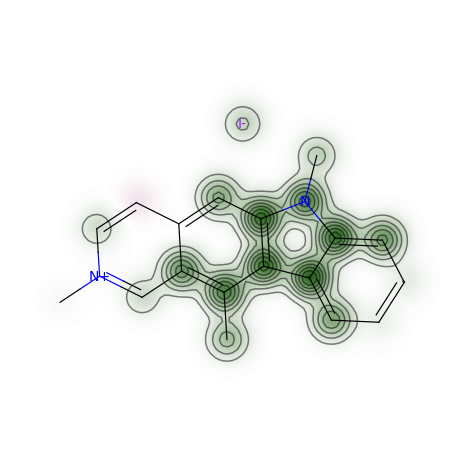

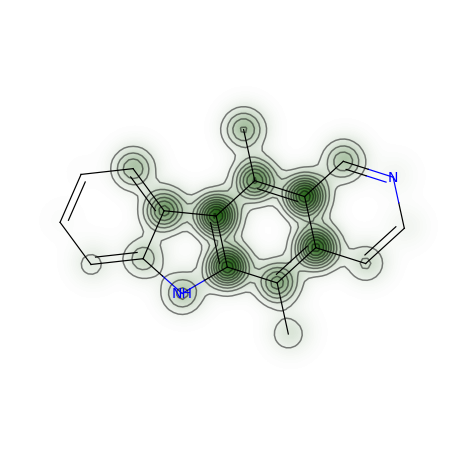

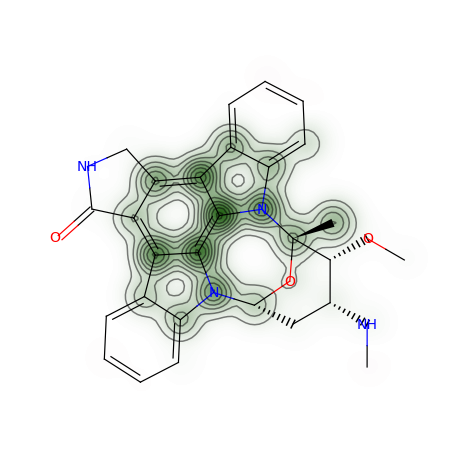

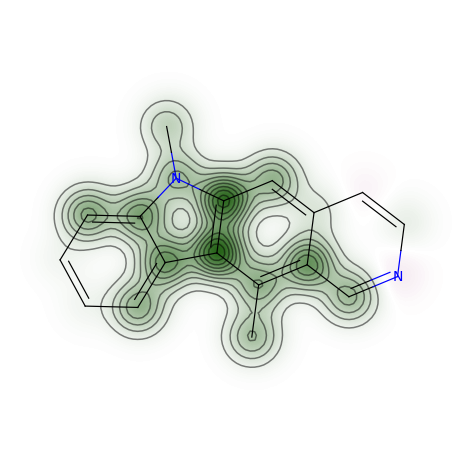

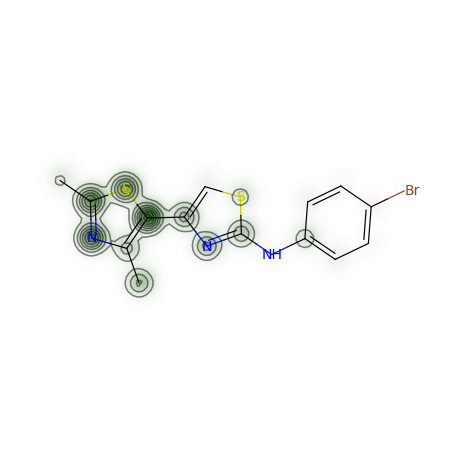

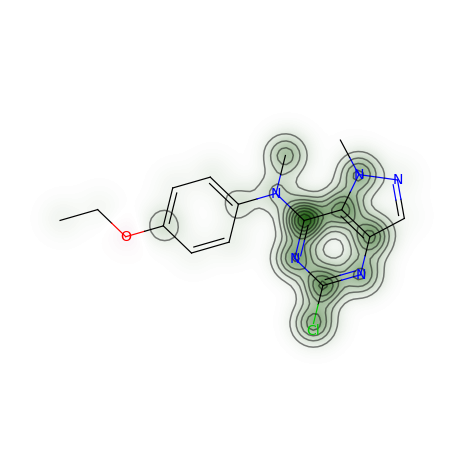

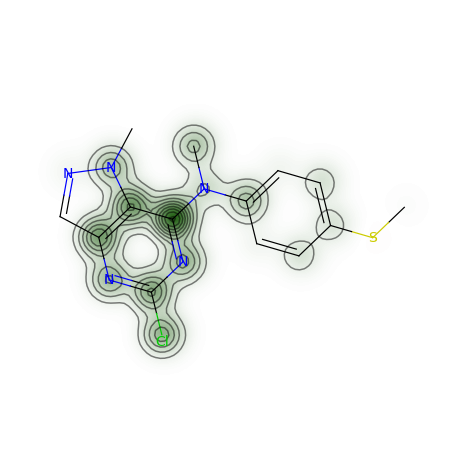

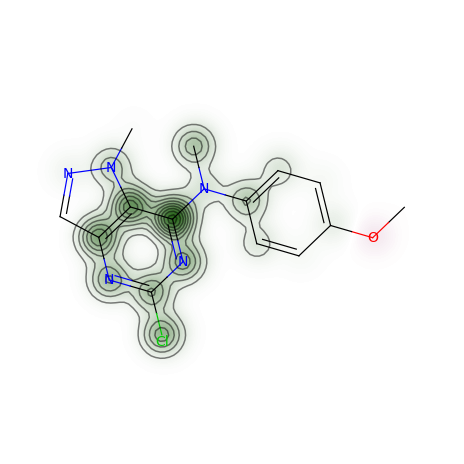

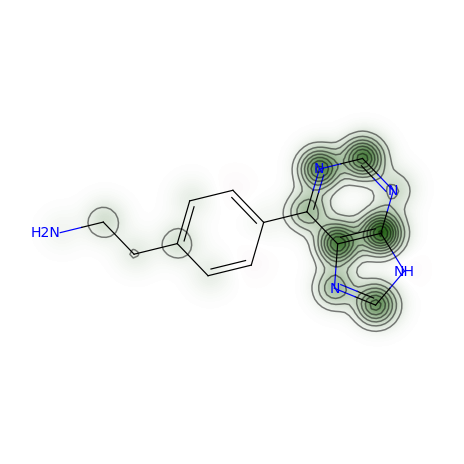

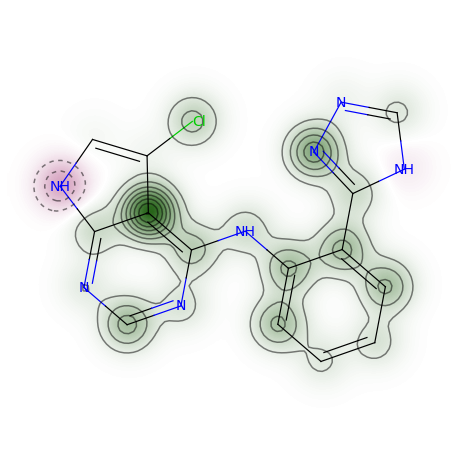

In [ ]:
vis_contribs(mols, mol_df, 'smi')

In [ ]:
#dir(mols[0])
testvar = mols[0]
print(testvar)

In [ ]:
print(model.model_dir)
print(dir(model))
model.save_checkpoint()
"""
f = open('model.pickle', 'wb')
pickle.dump(model, f)
f.close()
"""

/tmp/tmp_u_r4zgs
['__class__', '__del__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', '_built', '_checkpoint', '_compute_model', '_create_assignment_map', '_create_gradient_fn', '_create_inputs', '_create_training_ops', '_create_value_map', '_ensure_built', '_global_step', '_gradient_fn_for_vars', '_input_dtypes', '_input_shapes', '_inputs_built', '_label_dtypes', '_log_scalar_to_tensorboard', '_loss_fn', '_loss_outputs', '_other_outputs', '_output_functions', '_predict', '_prediction_outputs', '_prepare_batch', '_tf_optimizer', '_training_ops_built', '_variance_outputs', '_weights_dtypes', 'batch_size', 'compute_saliency', 'default_generator', 'evaluate', 'evaluate_generator', 'fit', 'f

"\nf = open('model.pickle', 'wb')\npickle.dump(model, f)\nf.close()\n"

In [ ]:
best_compound = (compound_ids_and_smiles[4])

url = "https://cactus.nci.nih.gov/chemical/structure/{smiles}/stdinchikey".format(smiles = best_compound[1])
r = requests.get(url=url)
raw_inchikey = r.text
inchikey = raw_inchikey.split('=')[1]

print(inchikey)

zinc_url = 'https://zinc15.docking.org/substances/?inchikey={inchikey}'.format(inchikey = inchikey)
print(zinc_url)

UUKVBKHGDGVWSB-UHFFFAOYSA-N
https://zinc15.docking.org/substances/?inchikey=UUKVBKHGDGVWSB-UHFFFAOYSA-N


# 4. Propose an assay

In [ ]:
#!pip install seaborn

In [ ]:
import seaborn
from matplotlib.pyplot import hist
from sklearn.neighbors import KernelDensity
from scipy import stats
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from scipy.cluster.hierarchy import dendrogram
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import pandas as pd

,index,compound_id,smiles,type,standard_value,assay_id,assay_type,assay_description,document_id,abstract,target_ensemble_id
0,0,CHEMBL570841,N=C1NC(=O)/C(=C/c2ccc(O)cc2)S1,IC50,12000.0,CHEMBL3377973,B,In vitro inhibition of purified recombinant Mr...,CHEMBL3352588,"During the last decade, the use of small molec...",ENSG00000020922
1,1,CHEMBL570841,N=C1NC(=O)/C(=C/c2ccc(O)cc2)S1,IC50,66000.0,CHEMBL3377972,B,Inhibition of Mre11 exonuclease activity (unkn...,CHEMBL3352588,"During the last decade, the use of small molec...",ENSG00000020922
2,0,CHEMBL4128424,O=C(COc1ccc2c(-c3ccccc3)cc(=O)oc2c1)NN1C(=O)CS...,IC50,2890.0,CHEMBL4123910,B,Inhibition of tubulin beta polymerization in h...,CHEMBL4118208,A new set of 4-phenylcoumarin derivatives was ...,ENSG00000196230
3,1,CHEMBL107,COc1cc2c(c(OC)c1OC)-c1ccc(OC)c(=O)cc1[C@@H](NC...,IC50,4590.0,CHEMBL4259781,B,Inhibition of tubulin beta polymerization in h...,CHEMBL4257538,"A novel series of sulfonamide derivatives, cou...",ENSG00000196230
4,2,CHEMBL4127437,COc1cc(C2SCC(=O)N2NC(=O)COc2ccc3c(-c4ccccc4)cc...,IC50,6130.0,CHEMBL4123910,B,Inhibition of tubulin beta polymerization in h...,CHEMBL4118208,A new set of 4-phenylcoumarin derivatives was ...,ENSG00000196230
...,...,...,...,...,...,...,...,...,...,...,...
13747,995,CHEMBL7976,O=C(/C=C/c1ccccc1)c1ccccc1,IC50,620000.0,CHEMBL4307262,B,Inhibition of tubulin polymerization (unknown ...,CHEMBL4304785,"Curcumin (CU), an edible natural pigment from ...",ENSG00000261456
13748,996,CHEMBL107,COc1cc2c(c(OC)c1OC)-c1ccc(OC)c(=O)cc1[C@@H](NC...,IC50,800000.0,CHEMBL816885,F,Inhibitory concentration required against tubu...,CHEMBL1134259,"A series of 2',3',4',6,7-substituted 2-aryl qu...",ENSG00000261456
13749,997,CHEMBL18869,COc1cccc(-c2nc(O)c3cc(OC)ccc3n2)c1,IC50,4900000.0,CHEMBL816885,F,Inhibitory concentration required against tubu...,CHEMBL1134259,"A series of 2',3',4',6,7-substituted 2-aryl qu...",ENSG00000261456
13750,998,CHEMBL278647,COc1cccc(-c2nc(O)c3cc(OC)c(OC)cc3n2)c1,IC50,6500000.0,CHEMBL816885,F,Inhibitory concentration required against tubu...,CHEMBL1134259,"A series of 2',3',4',6,7-substituted 2-aryl qu...",ENSG00000261456


1247
largest cluster: Cluster 0, Size: 418
Cluster 0: The global pandemic of drug-sensitive cancers and the increasing threat from drug-resistant cancers make an urgent need to develop more effective anti-cancer candidates. Quinolone derivatives possess promising anti-cancer activity, and some of them have already been approved to treat cancers or under clinical trials. Hybridization of quinolone with other anti-cancer pharmacophores may provide more efficient anti-cancer candidates, so quinolone hybrids worth to be investigated. In this review, the recent advances in the development of novel quinolone hybrids as potential anti-cancer agents are highlighted, and the structure-activity relationship is also discussed to provide an insight for further development of more active quinolone hybrids.
Cluster 1: A series of 3,4-disubstituted piperidine derivatives were obtained based on a conformational restriction strategy and a lead compound, <b>A12</b>, that exhibited potent in vitro and in

/home/ubuntu/.local/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


  (0, 7851)	0.15708383252434593
  (0, 7823)	0.049326199243429104
  (0, 7692)	0.09378246232093414
  (0, 7591)	0.06714698463086823
  (0, 7413)	0.11832832412159691
  (0, 7401)	0.09044570597114406
  (0, 7283)	0.15294198120692082
  (0, 7282)	0.04077187703151108
  (0, 7213)	0.07640651535656133
  (0, 7210)	0.05730380582552815
  (0, 7079)	0.07375258158149084
  (0, 7034)	0.07106150060750507
  (0, 6894)	0.0823692865404243
  (0, 6848)	0.22455485951817855
  (0, 6567)	0.07620613189443978
  (0, 6503)	0.10219395246163201
  (0, 6377)	0.14159711798725472
  (0, 6369)	0.09422490462557224
  (0, 6166)	0.15708383252434593
  (0, 6163)	0.15708383252434593
  (0, 6112)	0.19027394875196213
  (0, 6051)	0.10219395246163201
  (0, 6033)	0.13516955071373507
  (0, 5594)	0.09812041370505065
  (0, 5593)	0.08702871982004502
  :	:
  (1246, 2515)	0.047619840752885105
  (1246, 2372)	0.09561861113777645
  (1246, 2120)	0.15365287874385194
  (1246, 2017)	0.04385519909214047
  (1246, 1874)	0.05729811077344111
  (1246, 1849)	0.0

/home/ubuntu/.local/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


'\ntagger = Classifier.load(\'hunflair\')\nprint("Finished setting tagger")\n\nAssay_Descriptions_List = []\n\nsentence = Sentence(Assay_Descriptions_Joined)\ntagger.predict(sentence)\n\nAssay_Key_Words = ""\nfor label in sentence.get_labels():\n    Assay_Key_Words += label.data_point.text\n    Assay_Key_Words += " "\n    #print(label.data_point.text)\n    #print(Assay_Key_Words)\n\n#adds the Descriptions of the Assays to the Assay Description List\nAssay_Descriptions_List.append(Assay_Key_Words)\n\ndef tokenize_with_flair(description):\n    sentence = Sentence(description)\n    tagger.predict(sentence)\n    return [ l.data_point.text for l in sentence.get_labels() ]\n\n\n\nAssay_Count_Vect = CountVectorizer(tokenizer=tokenize_with_flair)\nAssay_Train_Counts = Assay_Count_Vect.fit_transform(Assay_Descriptions_List)\n\nn_clusters = 10  # number of regions\nX = Assay_Train_Counts.toarray()\n\nward = AgglomerativeClustering(\n    n_clusters = n_clusters, linkage="ward", connectivity=None,

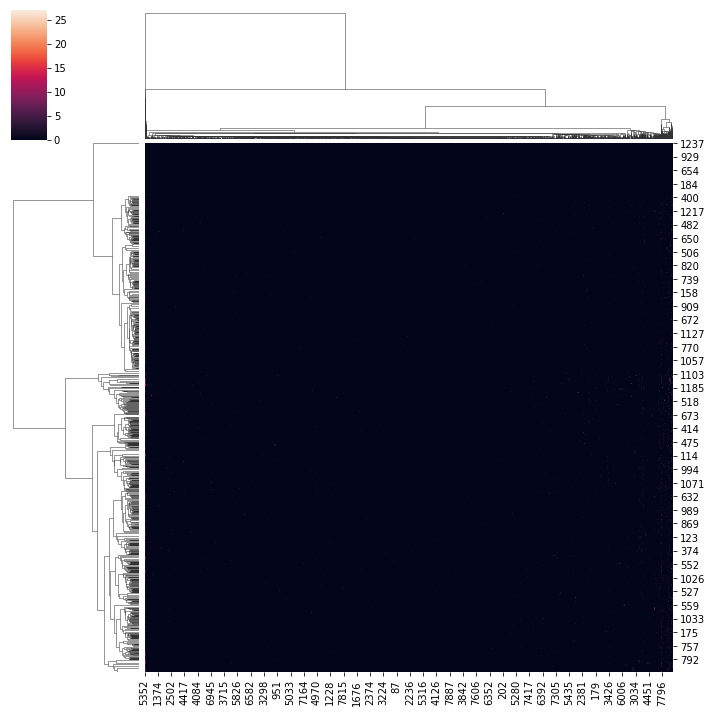

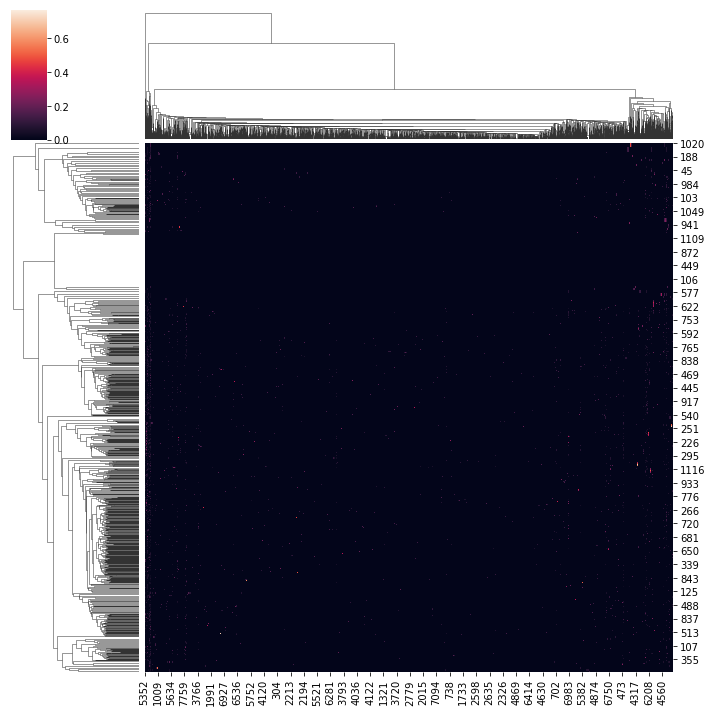

In [ ]:
"""
insert code here that
1. retrieves the terms for all the assays that are relevant to the target the user picked.
2. clusters the assays according to their descriptive terms
3. plots the clusters (set n_clusters = 10)
4. prints out the title of one assay from each cluster.
"""

config = dotenv_values("database_url.env")
url = config['DATABASE_URL']
engine = create_engine(url, echo=False)

with engine.begin() as conn:
    query = text("select * from target_to_compounds;")
    target_list = pd.read_sql(query, conn)
display(target_list)


three_col_list = target_list[['assay_id', 'assay_description', 'abstract']].copy()

unique_list = []
for index, row in three_col_list.iterrows():
    if (row["assay_id"], row["assay_description"], row["abstract"]) in unique_list:
        continue
    else:
        unique_list.append((row["assay_id"], row["assay_description"], row["abstract"]))

Assay_Descriptions = [abstract for (assay_ids, assay_name, abstract) in unique_list]
Assay_Descriptions_Joined = ':: '.join(Assay_Descriptions)

print(len(unique_list))
#print(unique_list)
#print(Assay_Descriptions)


Assay_Descriptions_List = Assay_Descriptions


Assay_Count_Vect = CountVectorizer()
Assay_Train_Counts = Assay_Count_Vect.fit_transform(Assay_Descriptions_List)
n_clusters = 20
X = Assay_Train_Counts.toarray()

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(Assay_Train_Counts)
tf_idf_vector = tfidf_transformer.transform(Assay_Train_Counts)


ward = AgglomerativeClustering(
    n_clusters = n_clusters, linkage="ward", connectivity=None, compute_full_tree= True,compute_distances= True
)
ward.fit(X)



unique_labels, counts = np.unique(ward.labels_, return_counts=True)
cluster_sizes = dict(zip(unique_labels, counts))

largest_cluster_label = max(cluster_sizes, key=cluster_sizes.get)
largest_cluster_size = cluster_sizes[largest_cluster_label]

print(f"largest cluster: Cluster {largest_cluster_label}, Size: {largest_cluster_size}")

cluster_labels = ward.fit_predict(tf_idf_vector.toarray())



cluster_assay_descriptions = {}
for cluster_label, assay_description in zip(cluster_labels, Assay_Descriptions):
    if cluster_label not in cluster_assay_descriptions:
        cluster_assay_descriptions[cluster_label] = []
    cluster_assay_descriptions[cluster_label].append(assay_description)



sorted_clusters = sorted(cluster_assay_descriptions.keys())

for cluster_label in sorted_clusters:
    assay_descriptions = cluster_assay_descriptions[cluster_label]
    print(f"Cluster {cluster_label}: {assay_descriptions[0]}")

print(ward.distances_)
print(ward.distances_.shape)

X_Hist = ward.distances_
kernel = stats.gaussian_kde(X_Hist)
print(kernel(X_Hist))

seaborn.clustermap(X,method='ward')


df_idf = pd.DataFrame(tfidf_transformer.idf_,index=Assay_Count_Vect.get_feature_names_out(),columns=["idf_weights"])
df_idf.sort_values(by=['idf_weights'])

count_vector=Assay_Count_Vect.transform(Assay_Descriptions_List)


tf_idf_vector=tfidf_transformer.transform(count_vector)
print(tf_idf_vector)
tf_idf_vector.shape

feature_names = Assay_Count_Vect.get_feature_names_out()

first_document_vector=tf_idf_vector[0]


df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False)

seaborn.clustermap(tf_idf_vector.toarray(),method='ward')





"""
tagger = Classifier.load('hunflair')
print("Finished setting tagger")

Assay_Descriptions_List = []

sentence = Sentence(Assay_Descriptions_Joined)
tagger.predict(sentence)

Assay_Key_Words = ""
for label in sentence.get_labels():
    Assay_Key_Words += label.data_point.text
    Assay_Key_Words += " "
    #print(label.data_point.text)
    #print(Assay_Key_Words)

#adds the Descriptions of the Assays to the Assay Description List
Assay_Descriptions_List.append(Assay_Key_Words)

def tokenize_with_flair(description):
    sentence = Sentence(description)
    tagger.predict(sentence)
    return [ l.data_point.text for l in sentence.get_labels() ]



Assay_Count_Vect = CountVectorizer(tokenizer=tokenize_with_flair)
Assay_Train_Counts = Assay_Count_Vect.fit_transform(Assay_Descriptions_List)

n_clusters = 10  # number of regions
X = Assay_Train_Counts.toarray()

ward = AgglomerativeClustering(
    n_clusters = n_clusters, linkage="ward", connectivity=None, compute_full_tree= True,compute_distances= True
)
ward.fit(X)

print(ward.distances_)
print(ward.distances_.shape)

X_Hist = ward.distances_
#hist(X_Hist)
kernel = stats.gaussian_kde(X_Hist)
print(kernel(X_Hist))

#first dendogram
seaborn.clustermap(X,method='ward')

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(Assay_Train_Counts)


# print idf values
df_idf = pd.DataFrame(tfidf_transformer.idf_,index=Assay_Count_Vect.get_feature_names(),columns=["idf_weights"])

# sort ascending
df_idf.sort_values(by=['idf_weights'])

# count matrix
count_vector=Assay_Count_Vect.transform(Assay_Descriptions_List)

# tf-idf scores
tf_idf_vector=tfidf_transformer.transform(count_vector)
print(tf_idf_vector)
tf_idf_vector.shape

feature_names = Assay_Count_Vect.get_feature_names()

#get tfidf vector for first document
first_document_vector=tf_idf_vector[0]

#print the scores
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False)


#second dendogram
seaborn.clustermap(tf_idf_vector.toarray(),method='ward')
"""

In [ ]:
print(len(cluster_labels))
print(len(Assay_Descriptions))
print(cluster_assay_descriptions[4][0] == cluster_assay_descriptions[4][1])
print(cluster_assay_descriptions[4][9])

1247
1247
True
A series of C-2 pyrroloquinoline analogs designed to improve aqueous solubility were examined for herpesvirus polymerase and antiviral activity. Several analogs were identified that maintained the antiviral activity of the previous development candidate against HCMV, HSV-1 and VZV, but with significantly improved aqueous solubility.
